In [1]:
# inline plotting

%matplotlib inline

In [2]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, RocCurveDisplay, roc_auc_score

import pickle
import mlflow
from joblib import parallel_backend

import seaborn as sns

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc

# Sleep States Prediction

### Course project including exploratory data analysis, working with time series, prediction with SVM and Decision Tree.

### Context 

The "Zzz" you catch each night are crucial for your overall health. Sleep affects everything from your development to cognitive functioning. Even so, sleep research has proved challenging, due to the lack of naturalistic data capture alongside accurate annotation. If data science could help researchers better analyze wrist-worn accelerometer data for sleep monitoring, sleep experts could more easily conduct large-scale studies of sleep, thus improving the understanding of sleep's importance and function.

### Problem to solve

The lack of sleep could have implications for children and youth, especially those with mood and behavior difficulties. Sleep is crucial in regulating mood, emotions, and behavior in individuals of all ages, particularly children. By accurately detecting periods of sleep and wakefulness from wrist-worn accelerometer data, researchers can gain a deeper understanding of sleep patterns and better understand disturbances in children.

We can gain useful knowledge about sleep by developing models and determining a person's sleep state. The goal of this research is to detect sleep onset and wake.

### Data 

We have two datasets. The first one is wih recorded events - onset and wakeup. The second one is very large without events of interest, but with additional features.

### Read Dataset 1 

Let's read the first dataset and get sense of the data we have :)

In [3]:
sleep_events = pd.read_csv("data/train_events.csv")

In [4]:
sleep_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [5]:
sleep_events.shape

(14508, 5)

In [6]:
sleep_events.describe().T

,count,mean,std,min,25%,50%,75%,max
night,14508.0,15.120072,10.286758,1.0,7.0,14.0,21.0,84.0
step,9585.0,214352.123944,141268.408192,936.0,95436.0,200604.0,317520.0,739392.0


In [7]:
# Count of uniqie series observations

np.count_nonzero(sleep_events.series_id.unique())

277

In [8]:
sleep_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


#### Observations 

We have a relatevely small dataset with 277 unique persons' records of sleep events - "onset" and "wakeup". The data is logged in different nights - up to 84th night. There is a information about person's "step" number of event's occurence. 

There are missing values in columns "step" and "timestamp". Also we need to take care of data types for "series_id", "event", "timestamp".

#### Feature selection

The attribute "step" needs some attention in order to fill NaN observations. As the field is closely time related the best approach here is to linearly interpolate the missing data points. Let's visualize the data of this column, make transformation and visualize the results. 

In [9]:
sleep_events.step

0          4992.0
1         10932.0
2         20244.0
3         27492.0
4         39996.0
           ...   
14503    560604.0
14504    574620.0
14505    581604.0
14506         NaN
14507         NaN
Name: step, Length: 14508, dtype: float64

In [10]:
def plot_step(num_steps, steps):
    """
    This is function to visualize step attribute.
    
    Parameters:
    num_steps - full sequence of steps recorded (without repetition) as a timeline
    steps - actual recorded steps for each person
    """

    plt.plot(np.arange(0, num_steps), steps)

    plt.xlabel("n steps")
    plt.ylabel("step")
    plt.title("Step Development")
    plt.semilogx()
    plt.semilogy()
    plt.show()

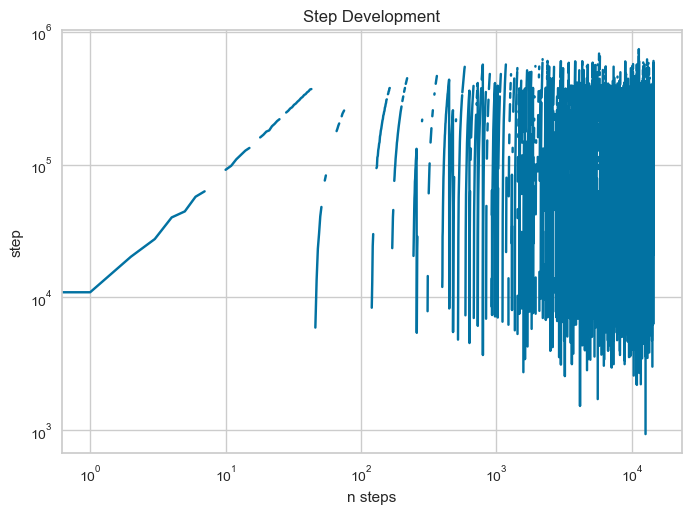

In [11]:
plot_step(len(sleep_events.step), sleep_events.step)

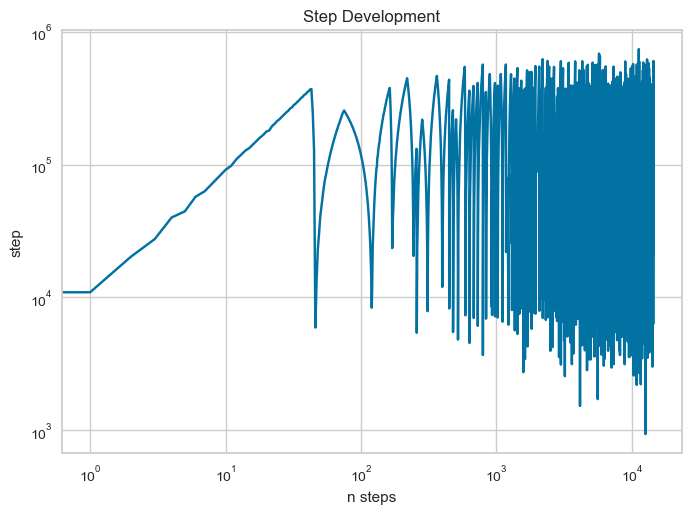

In [12]:
sleep_events["step"] = sleep_events.step.interpolate(Axis = 0)

plot_step(len(sleep_events.step), sleep_events.step)

Now the column "step" looks better. The results we see are expected and what we were aiming for.

Next column we need to take care of is "timestamp". We have missing values and not suitable data type format. First we will change type and then interpolate the column's values.

In [13]:
sleep_events["timestamp"] = sleep_events.timestamp.astype("datetime64[ns, UTC]")
sleep_events.timestamp

0       2018-08-15 02:26:00+00:00
1       2018-08-15 10:41:00+00:00
2       2018-08-15 23:37:00+00:00
3       2018-08-16 09:41:00+00:00
4       2018-08-17 03:03:00+00:00
                   ...           
14503   2017-09-06 08:07:00+00:00
14504   2017-09-07 03:35:00+00:00
14505   2017-09-07 13:17:00+00:00
14506                         NaT
14507                         NaT
Name: timestamp, Length: 14508, dtype: datetime64[ns, UTC]

In [14]:
# handle missing values in "timestamp"

sleep_events["timestamp"] = sleep_events["timestamp"].interpolate(Axis = 0)
sleep_events.timestamp

0       2018-08-15 02:26:00+00:00
1       2018-08-15 10:41:00+00:00
2       2018-08-15 23:37:00+00:00
3       2018-08-16 09:41:00+00:00
4       2018-08-17 03:03:00+00:00
                   ...           
14503   2017-09-06 08:07:00+00:00
14504   2017-09-07 03:35:00+00:00
14505   2017-09-07 13:17:00+00:00
14506   2017-09-07 13:17:00+00:00
14507   2017-09-07 13:17:00+00:00
Name: timestamp, Length: 14508, dtype: datetime64[ns, UTC]

Let's check all data types once more.

In [15]:
sleep_events.dtypes

series_id                 object
night                      int64
event                     object
step                     float64
timestamp    datetime64[ns, UTC]
dtype: object

Two of the attributes are recognised as string type. In nature "event" holds categorical values. The column "series_id" gives us differentiate the persons in the observations. In essence it is a descrete variable. 

We can use sklearn ordinal encoder to transform these values into numeric ones preserving their inherent ordering.

#### Encoding

In [16]:
encoder = OrdinalEncoder()

# nd array
cat_features = list(zip(sleep_events.series_id, sleep_events.event))

# cat_features
cat_features_transformed = encoder.fit_transform(cat_features)

In [17]:
sleep_events["series_id"], sleep_events["event"] = cat_features_transformed[:, 0], cat_features_transformed[:, 1]

In [18]:
sleep_events.event.unique()

array([0., 1.])

In [19]:
sleep_events.head()

,series_id,night,event,step,timestamp
0,0.0,1,0.0,4992.0,2018-08-15 02:26:00+00:00
1,0.0,1,1.0,10932.0,2018-08-15 10:41:00+00:00
2,0.0,2,0.0,20244.0,2018-08-15 23:37:00+00:00
3,0.0,2,1.0,27492.0,2018-08-16 09:41:00+00:00
4,0.0,3,0.0,39996.0,2018-08-17 03:03:00+00:00


There is something interesting we can check about this time series dataset. Let's see how the feature "step" is autocorrelated.

#### Visualize autocorrelation 

In [20]:
sleep_events_indexed = sleep_events.set_index("timestamp")

In [21]:
sleep_events_indexed.index.min(), sleep_events_indexed.index.max()

(Timestamp('2017-08-06 02:44:00+0000', tz='UTC'),
 Timestamp('2019-07-05 09:33:00+0000', tz='UTC'))

In [22]:
def plot_autocorr(data, n_lags):
    """
    Function to visualize autocorrelation using plot_acf.
    
    Parameters:
    data - column to be displayed
    n_lags - how many lags to be included
    """
    plot_acf(data, lags = n_lags)
    
    plt.xlabel("n_lags")
    plt.ylabel("Percentage autocorr")
    plt.show()

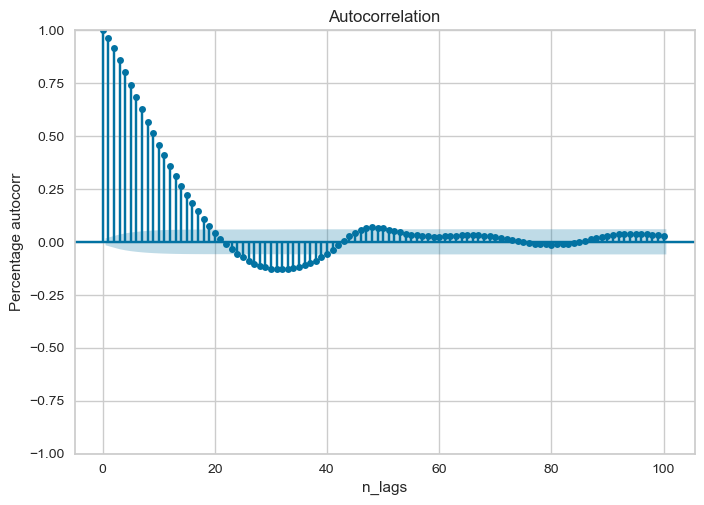

In [23]:
plot_autocorr(sleep_events_indexed.step, 100)

What we see here is very interesting. The autocorrelation is getting weaker as we are getting longer distance. After a specific moment it becomes insignificant - the slight blue area. This happens after 20 lags behind.

Let's check it more closely - with shorter interval.

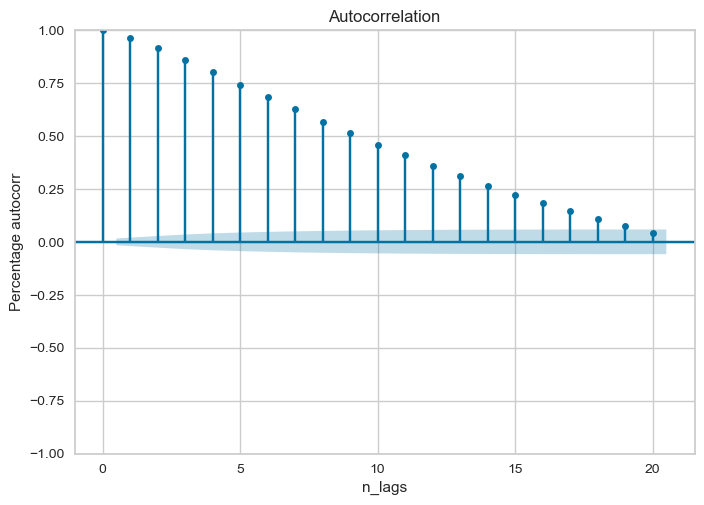

In [24]:
plot_autocorr(sleep_events_indexed.step, 20)

The inspection of the first dataset has finished. Now let's play a bit with the second one.

### Dataset 2

In [25]:
with parallel_backend("loky", n_jobs = 100):
    sleep_train = pd.read_parquet("data/train_series.parquet")

In [26]:
sleep_train.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [27]:
sleep_train.shape

(127946340, 5)

In [28]:
sleep_train.describe().T

,count,mean,std,min,25%,50%,75%,max
step,127946340.0,254804.797188,177892.965593,0.0,115812.0000,234519.0000,357196.0000,1.433879e+06
anglez,127946340.0,-8.810453,30.157093,-90.0,-31.8589,-9.5979,11.3002,9.000000e+01
enmo,127946340.0,0.041315,0.097438,0.0,0.0013,0.0172,0.0437,1.143370e+01


In [29]:
# number of unique series

np.count_nonzero(sleep_train.series_id.unique())

277

In [30]:
sleep_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  object 
 1   step       uint32 
 2   timestamp  object 
 3   anglez     float32
 4   enmo       float32
dtypes: float32(2), object(2), uint32(1)
memory usage: 3.3+ GB


In [31]:
sleep_train.timestamp.min()

'2017-08-04T17:30:00-0400'

In [32]:
sleep_train.timestamp.max()

'2019-07-09T09:44:55-0400'

#### Observations

The second dataset is sensibly larger. The total unique ids are the same count in both tables. We can conclude that this data represents the observations of the same people (same ids). It includes all records of their routine and lacks the labeling of the two events of interest - "onset" and "wakeup". Two additional features we gain - "anglez" and "enmo". 

There are no missing values. Two of the attributes are type "object" - "series_id" and "timestamp".

The time interval is the same in both datasets.

We need to think of how to merge the two tables. The data match on the granularity. Let's change the types of columns "step" and "series_id" to prepare them for a merge.

#### Feature Transformations

In [33]:
sleep_train["step"] = sleep_train.step.astype(float)

In [34]:
# convert series_id to float64.

series_ids = np.array(sleep_train.series_id).reshape(-1, 1)

series_ids = encoder.fit_transform(series_ids)

In [35]:
sleep_train["series_id"] = series_ids

In [36]:
sleep_train.dtypes

series_id    float64
step         float64
timestamp     object
anglez       float32
enmo         float32
dtype: object

In [37]:
sleep_train.head()

,series_id,step,timestamp,anglez,enmo
0,0.0,0.0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,0.0,1.0,2018-08-14T15:30:05-0400,2.6368,0.0215
2,0.0,2.0,2018-08-14T15:30:10-0400,2.6370,0.0216
3,0.0,3.0,2018-08-14T15:30:15-0400,2.6368,0.0213
4,0.0,4.0,2018-08-14T15:30:20-0400,2.6368,0.0215


### Merge train dataset with labels and useful features

In [ ]:
# merge useful information 

with parallel_backend("loky", n_jobs = 300):
    sleep_train_labeled = pd.merge(sleep_train, sleep_events, how = "left", on = ["series_id", "step"], sort = False)

In [ ]:
sleep_train_labeled.head()

In [ ]:
sleep_train_labeled.shape

In [ ]:
sleep_train_labeled.info()

The new dataset consists of the two datasets merged on "series_id" and "step". The data keeps the original ordering. As the second dataset is larger the order follows the order of the bigger dataset.

We end here with events that are none, e.g. we get missing values for column "event" for the records of the second dataset that do not match records from the first one.

As per documentation there is only one sleep logged in the first dataset per series_id per night. We can then make the assumption that all these events (that are not matching and are none) represent an activity that doesn't interests us.

Although the second table is very large it doesn't provide us in essence with significant information, as its events are "no events". We get high quantities of close to insignificant data. 

I decided to replace nones with -1.

In [ ]:
sleep_train_labeled["event"] = sleep_train_labeled.event.fillna(-1)

sleep_train_labeled.event.unique()

There is a huge class imbalance we need to approach.

We need to show during training enough "no events" just to give our algorithm sense of what is not an event that interests us. I assume that the loss of "no event" data won't detain the algorithm to learn correctly the behavior of the dependant variable.  

One very hard decision, but I think most logical thing to do, is to resample the merged data in order to balance the classes. 

Then I decided to cut down to 5356 the observations with "no event". 

### Undersampling

In [ ]:
# count the classes

class_counts = sleep_train_labeled.event.value_counts()
class_counts

In [ ]:
# find the minimum class counts

min_class_count = class_counts.min()
min_class_count

One very mportant thing is to keep the original timeline. Through some experiments we get to the knowledge that timeline weights on the work of the algorithm and brought worse results when rows were randomly selected. The preservation of the historical order is important as it gives the patterns of "sleep events".

With other words we need to make the resampling without shuffling the observations. 

In [ ]:
# Resample each class to have an equal number of samples without shuffling

sleep_train_resampled = sleep_train_labeled.groupby("event", group_keys = False).apply(lambda x: x.head(min_class_count))
sleep_train_resampled.head()

In [ ]:
sleep_train_resampled.event.value_counts()

Before we continue let's separate the attributes and labels columns.

#### Separate attributes from labels

In [ ]:
sleep_train_att_resample = sleep_train_resampled.drop(columns = "event")

In [ ]:
sleep_train_att_resample.shape

In [ ]:
sleep_train_lab_resample = sleep_train_resampled.event

In [ ]:
sleep_train_lab_resample.shape

We need to make some final transformations on the values, as when merged we get "timestamp" column twice.

### Feature engeneering

In [ ]:
sleep_train_att_resample["timestamp_x"] = sleep_train_att_resample.timestamp_x.astype("datetime64[ns, UTC]")

In [ ]:
sleep_train_att_resample.dtypes

In [ ]:
# Merge two columns timestamp in one

sleep_train_att_resample["timestamp"] = sleep_train_att_resample.timestamp_y.fillna(sleep_train_att_resample.timestamp_x)
sleep_train_att_resample = sleep_train_att_resample.drop(columns = ["timestamp_x", "timestamp_y"])
sleep_train_att_resample.head()

We want to give some higher order features to the algorithm. I assume they might be of big use to understand the wanted function.

#### Higher Order Features

In [ ]:
# Add columns date and hour

sleep_train_att_resample["date"] = sleep_train_att_resample.timestamp.dt.date
sleep_train_att_resample["hour"] = sleep_train_att_resample.timestamp.dt.hour

In [ ]:
# Add time delta and step delta between events

sleep_train_att_resample["step_diff"] = sleep_train_att_resample.groupby("series_id")["step"].diff()
sleep_train_att_resample["hour_diff"] = sleep_train_att_resample.groupby("series_id")["hour"].diff()

In [ ]:
# Working out the 24 hours substraction

hour_diff = [hour_diff + 24 if hour_diff < 0 else hour_diff for hour_diff in sleep_train_att_resample.hour_diff]
sleep_train_att_resample.hour_diff = hour_diff

In [ ]:
# Add four new columns for each observation as a "step" sliding window 

def create_shifted_columns(dataset, column_name, shift_range):
    """
    Functions to create new columns that holds information of previous lags.
    
    Parameters:
    dataset - dataset name
    column_name - column name to be used for the shift
    shift_range - how many columns to be made and lags 
    """
    for shift in shift_range:
        new_column_name = f"{column_name}_shifted_{shift}"
        dataset[new_column_name] = dataset[column_name].shift(shift)

    return dataset

In [ ]:
sleep_train_att_resample = create_shifted_columns(sleep_train_att_resample, "step", range(2, 6))

In [ ]:
# Fill NA

sleep_train_att_resample = sleep_train_att_resample.fillna(0)
sleep_train_att_resample.head()

At this point we already derived the usefull information from "timestamp". Features "series_id", "night", "timestamp" and "date" contain of high entropy. They are not useful features for the predictions and we can drop them.  

#### Drop Columns

In [ ]:
sleep_train_att_resample = sleep_train_att_resample.drop(columns = ["series_id", "night", "timestamp", "date"])

In [ ]:
sleep_train_att_resample.dtypes

I am curious about the features "anglez" and "enmo". Let's visualize them to better undersand what we have. 

#### Distributions of variables "anglez" and "enmo"

Z-angle is a metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body.

In [ ]:
def show_distr(dataset, column, num_bins):
    """
    Visualize variable distribution.
    
    Parameters:
    dataset - name of the dataset
    column - name of the column
    num_bins - number of bins to display
    """

    plt.hist(dataset[column], alpha = 0.7)
    
    plt.semilogy()
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(column)
    plt.show()

In [ ]:
show_distr(sleep_train_att_resample, "anglez", "fd")

What we see is close to Gaussian distribution. There are equally spread values around the median, which centers at zero. For better understanding let's check minimum and maximum value.

In [ ]:
min_anglez, max_anglez = sleep_train_att_resample.anglez.min(), sleep_train_att_resample.anglez.max()

In [ ]:
min_anglez, max_anglez

Anglez feature is with Gaussian distribution, so we will use standart scaling for its values.

ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. Let's see how "enmo" distribution looks like. 

In [ ]:
show_distr(sleep_train_att_resample, "enmo", "fd")

In [ ]:
min_enmo, max_enmo = sleep_train_att_resample.enmo.min(), sleep_train_att_resample.enmo.max()

In [ ]:
min_enmo, max_enmo

We see typical exponential decay, distributed between 0 and 1.2.

Enmo feature is with Exponential distribution, so we will use MinMax scaling for its values.

### Features Engeneering
#### Scaling the data

To assure all data points lie in the same scale, we need to do some rescaling. All features are suitable for MinMaxScaler, except "anglez". We will transform "anglez" on the standard scale.

##### Anglez with StandardScaler

In [ ]:
std_scaler = StandardScaler()

In [ ]:
anglez = np.array(sleep_train_att_resample.anglez).reshape(-1, 1)

In [ ]:
std_scaler.fit(anglez)

In [ ]:
anglez = std_scaler.transform(anglez)

In [ ]:
anglez.min(), anglez.max(), anglez.mean(), anglez.std()

##### Others with MinMaxScaler

In [ ]:
mm_scaler = MinMaxScaler()

In [ ]:
mm_features = np.array(sleep_train_att_resample.drop(columns = ["anglez"]))

In [ ]:
mm_scaler.fit(mm_features)

In [ ]:
mm_features = mm_scaler.transform(mm_features)

In [ ]:
col_names = ["step", "enmo", "hour", "step_diff", "hour_diff", "step_shifted_2", "step_shifted_3", "step_shifted_4", "step_shifted_5"]

In [ ]:
sleep_train_att_resample = pd.DataFrame(mm_features)

In [ ]:
sleep_train_att_resample.columns = col_names

In [ ]:
sleep_train_att_resample["anglez"] = anglez

In [ ]:
sleep_train_att_resample.head()

In [ ]:
sleep_train_att_resample.shape

One very important step on the way is to split our dataset to four pieces. All four pieces will be functionally separated to do different tasks. We need two pieces to train our models (attributes and labels) and two to perform some tests.

### Train and test split

In [ ]:
sleep_attributes, sleep_labels = sleep_train_att_resample, sleep_train_lab_resample

In [ ]:
sleep_attributes_train, sleep_attributes_test, sleep_labels_train, sleep_labels_test = train_test_split(sleep_attributes, sleep_labels, test_size = 0.35, random_state = 11)

There are two parameters that were fixed during this process. Random state so we could have reproducible research. Test size was fixed to 35% of total data. 

This is higher that the default size, as during algorithm testing I have the hypothesis that testset was too easy in some way. I get consistently higher accuracy scores on the testset than the trainset.

It is good and timesaving practice to save these 4 final data pieces as pickle objects. This could save us tons of time to rerun the whole preprocessing.  

### Pickle Files

We did a great job. Let'save the train and test datasets with serialization.

In [ ]:
with open("sleep_attributes_train.pkl", "wb") as f:   # open a pkl file
    pickle.dump(sleep_attributes_train, f)            # serialize the attributes trainset
f.close

In [ ]:
with open("sleep_attributes_test.pkl", "wb") as f:   # open a pkl file
    pickle.dump(sleep_attributes_test, f)            # serialize the attributes testset
f.close

In [ ]:
with open("sleep_labels_train.pkl", "wb") as f:   # open a pkl file
    pickle.dump(sleep_labels_train, f)            # serialize the labels trainset
f.close

In [ ]:
with open("sleep_labels_test.pkl", "wb") as f:   # open a pkl file
    pickle.dump(sleep_labels_test, f)            # serialize the labels testset
f.close

### Algorithm

We do a classification on 3 classes with relatively small dataset (16 065 records). Let's try SVMs and Decision Tree (or Forest/s) for our predictive algorithm. 

### SVMs 
For 3 classes the algorithm trains three algorithms separately as calculated in the formula:

$$ \frac{c \times (c - 1)}{2} $$

where $c$ = n_classes

SVMs computation is with high complexity, that strongly depends on the number of observations, as well the number of features.
$$ m \times n^2 $$
$m$ - features
$n$ - observations

However our dataset is relatively small and suitable to be used with SVM.

### Nu SVM

In [ ]:
nu_svm = NuSVC(kernel = "rbf", 
               gamma = "scale", 
               nu = 0.28, 
               random_state = 11, 
               probability = True)

In [ ]:
nu_svm.fit(sleep_attributes_train, sleep_labels_train)

In [ ]:
predictions_nu_svm = nu_svm.predict(sleep_attributes_test)

In [ ]:
predictions_proba = nu_svm.predict_proba(sleep_attributes_test)

#### Evaluation metrics

In [ ]:
scores_nu_svm = cross_val_score(nu_svm, sleep_attributes_train, sleep_labels_train, cv = 4)
scores_nu_svm

In [ ]:
nu_svm.score(sleep_attributes_test, sleep_labels_test)

In [ ]:
len(nu_svm.support_vectors_)

In [ ]:
nu_svm.intercept_

#### One-vs-one multiclass ROC

In [ ]:
roc_auc_score = roc_auc_score(sleep_labels_test, predictions_proba, multi_class = "ovo")

In [ ]:
roc_auc_score

### Linear SVM

In [ ]:
lin_svm = LinearSVC(C = 0.6,
                       multi_class = "ovr",
                       dual = "auto",
                       random_state = 11)

In [ ]:
lin_svm.fit(sleep_attributes_train, sleep_labels_train)

In [ ]:
predictions_lin_svm = lin_svm.predict(sleep_attributes_test)

#### Evaluation Metrics

In [ ]:
cv_scores_lin_svm = cross_val_score(lin_svm, sleep_attributes_train, sleep_labels_train, cv = 4)
cv_scores_lin_svm

In [ ]:
lin_svm.score(sleep_attributes_test, sleep_labels_test)

In [ ]:
lin_svm.coef_

### Polinomial SVM

In [ ]:
poly_svm = SVC(C = 1, 
               kernel = "poly", 
               degree = 2, 
               random_state = 11)

In [ ]:
poly_svm.fit(sleep_attributes_train, sleep_labels_train)

In [ ]:
predictions_poly_svm = poly_svm.predict(sleep_attributes_test)

#### Evaluation Metrics

In [ ]:
cv_scores_poly_svm = cross_val_score(poly_svm, sleep_attributes_train, sleep_labels_train, cv = 4)
cv_scores_poly_svm

In [ ]:
poly_svm.score(sleep_attributes_test, sleep_labels_test)

In [ ]:
poly_svm.classes_

In [ ]:
poly_svm.class_weight_

In [ ]:
poly_svm.dual_coef_

### Decision Tree

In [ ]:
tree = DecisionTreeClassifier(criterion = "gini", splitter = "best", max_depth = 10, random_state = 11)

In [ ]:
tree.fit(sleep_attributes_train, sleep_labels_train)

In [ ]:
predictions_tree = tree.predict(sleep_attributes_test)

In [ ]:
tree.feature_importances_

In [ ]:
permutation_importance(tree, sleep_attributes_train, sleep_labels_train)

In [ ]:
tree.feature_names_in_

#### Evaluation Metrics

In [ ]:
cv_scores_tree = cross_val_score(tree, sleep_attributes_train, sleep_labels_train, cv = 4)
cv_scores_tree

In [ ]:
tree.score(sleep_attributes_test, sleep_labels_test)

### Other Evaluation Metrics

#### Classification report

In [ ]:
labels_names = ["no_event", "onset", "wakeup"]

In [ ]:
print("Nu SVM " + classification_report(sleep_labels_test, predictions_nu_svm))
print("Linear SVM " + classification_report(sleep_labels_test, predictions_lin_svm))
print("Poly SVM " + classification_report(sleep_labels_test, predictions_poly_svm))
print("Decision Tree " + classification_report(sleep_labels_test, predictions_tree))

#### Classes histogram

Let's visualize the actual labels versus predictions. 

In [ ]:
def display_resuduals(actual_set_name, prediction_set_name, title):
    """
    Function to display resudual histogram.
    
    Parameters:
    actual_set_name - dataset name with actuals
    prediction_set_name - dataset name with predictions
    title - title of the diagram
    """
    
    plt.hist(actual_set_name, color = "c", alpha = 0.7, label = "Actuals")
    plt.hist(prediction_set_name, color = "y", alpha = 0.7, label = "Predictions")

    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.xticks([-1, 0, 1])
    plt.ylim(0, 2350)
    plt.legend()

In [ ]:
fig = plt.figure(figsize = (9, 11))
rows, cols = 2, 2

fig.add_subplot(rows, cols, 1)
display_resuduals(sleep_labels_test, predictions_nu_svm, "Nu SVM")

fig.add_subplot(rows, cols, 2)
display_resuduals(sleep_labels_test, predictions_lin_svm, "Linear SVM")

fig.add_subplot(rows, cols, 3)
display_resuduals(sleep_labels_test, predictions_poly_svm, "Polinomial SVM")

fig.add_subplot(rows, cols, 4)
display_resuduals(sleep_labels_test, predictions_tree, "Decision Tree")

plt.show()

#### Confusion Matrix

In [ ]:
def make_cm_df(predictions):
    cm_name = confusion_matrix(sleep_labels_test, predictions)
    cm_df = pd.DataFrame(cm_name, index = labels_names, columns = labels_names)
    return cm_df

In [ ]:
def visualize_cm(data, title):
    """
    Plots a Confusion Matrix.
    
    Parameters:
    data - dataset name
    title - title for the matrix
    """
    sns.heatmap(data
            , annot = True
            , fmt = "g"
            , cmap = "crest"
           )
    plt.ylabel("Prediction", fontsize = 13)
    plt.xlabel("Actual", fontsize = 13)
    plt.title(title, fontsize = 17)
    plt.show()

In [ ]:
visualize_cm(make_cm_df(predictions_nu_svm), "Nu SVM Confusion Matrix")

In [ ]:
visualize_cm(make_cm_df(predictions_lin_svm), "Linear SVM Confusion Matrix")

In [ ]:
visualize_cm(make_cm_df(predictions_poly_svm), "Poly SVM Confusion Matrix")

In [ ]:
visualize_cm(make_cm_df(predictions_tree), "Decision Tree Confusion Matrix")

#### Visualize ROC curve
This plot allows us to visualize the tradeoff between the classifier’s sensitivity and specificity.

In [ ]:
def display_roc_auc(model):
    roc_auc(model, sleep_attributes_train, sleep_labels_train, X_test = sleep_attributes_test, y_test = sleep_labels_test)

In [ ]:
display_roc_auc(nu_svm)

In [ ]:
display_roc_auc(lin_svm)

In [ ]:
display_roc_auc(poly_svm)

In [ ]:
display_roc_auc(tree)

### Final Conclusions
All four algorithms make amazing job. However according to all evaluation metrics shown a single decision tree beats them all. 

There is something very important to be noticed. No matter the algorithm types and hyperparameter tuning, the thing that brought us these amazing results is the right preprocessing of the data.

### References

[sklearn doc](https://scikit-learn.org/stable/)

[neptune ai](https://neptune.ai/blog/time-series-prediction-vs-machine-learning)

[towardsdatascience time series](https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe)

[ml-cheatsheet](https://ml-cheatsheet.readthedocs.io/en/latest/classification_algos.html?highlight=svm#support-vector-machine)

[analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/#Confusion_Matrix_for_Multi-Class_Classification)

[medium yellowbrick](https://afioto.medium.com/classification-visualizations-with-yellowbrick-d6f6150d7a32)

[freecodecamp](https://www.freecodecamp.org/news/machine-learning-pipeline/#:~:text=There%20is%20a%20big%20difference,ColumnTransformer%20that%20you%20should%20understand.&text=You%20use%20the%20pipeline%20for,separately%20before%20combining%20them%20later)

[medium pipelines](https://medium.com/analytics-vidhya/getting-started-with-scikit-learn-pipelines-for-machine-learning-fa88efdca3b9)

[open ai](https://openai.com)

[scikit-yb.org](https://www.scikit-yb.org/en/latest/api/classifier/index.html)

[towardsai.net](https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff)

[towardsdatascience ROCAUC](https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077)